In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from pathlib import Path

from gensim.models.doc2vec import Doc2Vec
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.autolayout"] = True

In [2]:
data_dir = Path(Path.cwd().parent, 'data/interim')
models_dir = Path(Path.cwd().parent, 'models')
evals_dir = Path(data_dir, 'evals_4')
labels_dir = Path(data_dir, 'labels_2')
models_dir = Path(Path.cwd().parent, 'models')
datasets_order = {
    'chains_eq_2': 0,
    'chains_eq_3': 1,
    'chains_ge_4_lt_10': 2,
    'chains_ge_10': 3}

datasets_names = {
    'chains_eq_2': r'CL $= 2$',
    'chains_eq_3': r'CL $= 3$',
    'chains_ge_4_lt_10': r'10 $>$ CL $\geq$ 4',
    'chains_ge_10': r'CL $\geq$ 10'}

sizes = {}
for path in Path(models_dir).glob('d2v*.model'):
    size = len(Doc2Vec.load(str(path)).dv.vectors)
    name = '_'.join(path.stem.split('_')[1:])
    sizes[name] = size
    
score_names = [
    f'Worse{" "*12}Silhouette{" "*12}Better',
    f'Worse{" "*8}Calinski-Harabasz{" "*8}Better',
    f'Better{" "*10}Davies-Bouldin{" "*10}Worse',
    f'Stable{" "*16}Entropy{" "*16}Unstable'
]

In [3]:
df_kmeans = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_km*.csv')], ignore_index=True)
df_kmeans['dimensions'] = df_kmeans['dataset'].apply(lambda s: s.split('_')[-1])
df_kmeans['dataset'] = df_kmeans['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_kmeans['order'] = df_kmeans['dataset'].map(datasets_order)
df_kmeans['name'] = df_kmeans['dataset'].map(datasets_names)
df_kmeans = df_kmeans.sort_values('order')
df_kmeans['k_noise'] = df_kmeans['n_clusters'].astype(int)
df_kmeans['method'] = 'KMeans'

df_dbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_dbscan*.csv')], ignore_index=True)
df_dbscan['size'] = df_dbscan['dataset'].map(sizes)
df_dbscan['prop_noise'] = df_dbscan['n_noise']/df_dbscan['size']
df_dbscan['dimensions'] = df_dbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_dbscan['dataset'] = df_dbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_dbscan['order'] = df_dbscan['dataset'].map(datasets_order)
df_dbscan['name'] = df_dbscan['dataset'].map(datasets_names)
df_dbscan = df_dbscan.sort_values('order')
df_dbscan['k_noise'] = df_dbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_dbscan['method'] = 'DBSCAN'

df_hdbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('*_hdbscan*.csv')], ignore_index=True)
df_hdbscan['size'] = df_hdbscan['dataset'].map(sizes)
df_hdbscan['prop_noise'] = df_hdbscan['n_noise']/df_hdbscan['size']
df_hdbscan['dimensions'] = df_hdbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_hdbscan['dataset'] = df_hdbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_hdbscan['order'] = df_hdbscan['dataset'].map(datasets_order)
df_hdbscan['name'] = df_hdbscan['dataset'].map(datasets_names)
df_hdbscan = df_hdbscan.sort_values('order')
df_hdbscan['k_noise'] = df_hdbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_hdbscan['method'] = 'HDBSCAN'
datasets = df_dbscan.sort_values(by='order')['dataset'].unique()

scores = ['sl_score', 'ch_score', 'db_score', 'entropy']

# KMeans

In [4]:
df_kmeans

distance       dataset  n_clusters  sl_score    ch_score   db_score  \
788  euclidean   chains_eq_2           3  0.060874  404.989444   8.826893   
735  euclidean   chains_eq_2           2  0.188361  623.317562   5.973547   
736  euclidean   chains_eq_2           3  0.060874  404.989444   8.826893   
737  euclidean   chains_eq_2           4 -0.003571  299.974224  10.665293   
787  euclidean   chains_eq_2           2  0.188361  623.317562   5.973547   
..         ...           ...         ...       ...         ...        ...   
484         l2  chains_ge_10          45 -0.155634   13.864593   7.054532   
483         l2  chains_ge_10          44 -0.141554   13.969439   6.970782   
482         l2  chains_ge_10          43 -0.141163   14.113437   6.955933   
142         l2  chains_ge_10          46 -0.186811    6.692849  10.419353   
957     cosine  chains_ge_10          23 -0.036943   30.898580   5.726240   

      entropy dimensions  order          name  k_noise  method  
788  1.021013        300      0      CL $= 2$        3  KMeans  
735  0.648162        300      0      CL $= 2$        2  KMeans  
736  1.021013        300      0      CL $= 2$        3  KMeans  
737  1.287573        300      0      CL $= 2$        4  KMeans  
787  0.648162        300      0      CL $= 2$        2  KMeans  
..        ...        ...    ...           ...      ...     ...  
484  3.721927         50      3  CL $\geq$ 10       45  KMeans  
483  3.640870         50      3  CL $\geq$ 10       44  KMeans  
482  3.630275         50      3  CL $\geq$ 10       43  KMeans  
142  3.683094        300      3  CL $\geq$ 10       46  KMeans  
957  3.068996         50      3  CL $\geq$ 10       23  KMeans  

[1181 rows x 12 columns]

In [5]:
iter_dataset = iter(df_kmeans.sort_values(by='order')['dataset'].unique())

chains_eq_2


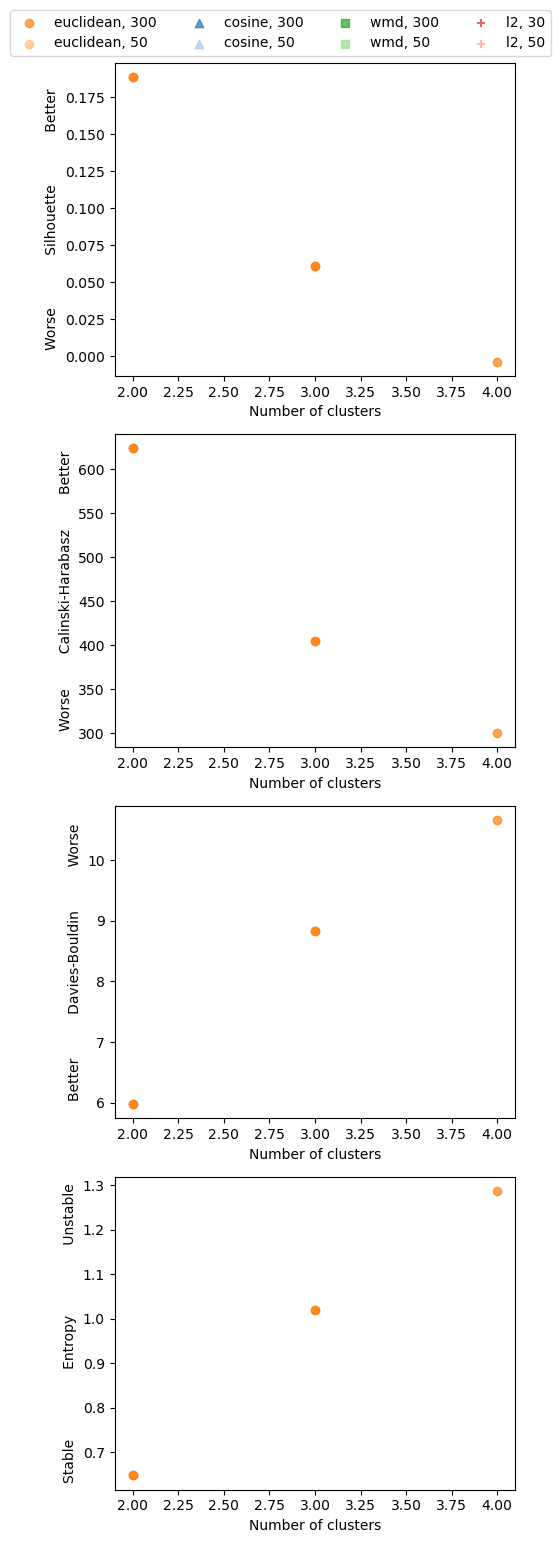

In [6]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=4)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

chains_eq_3


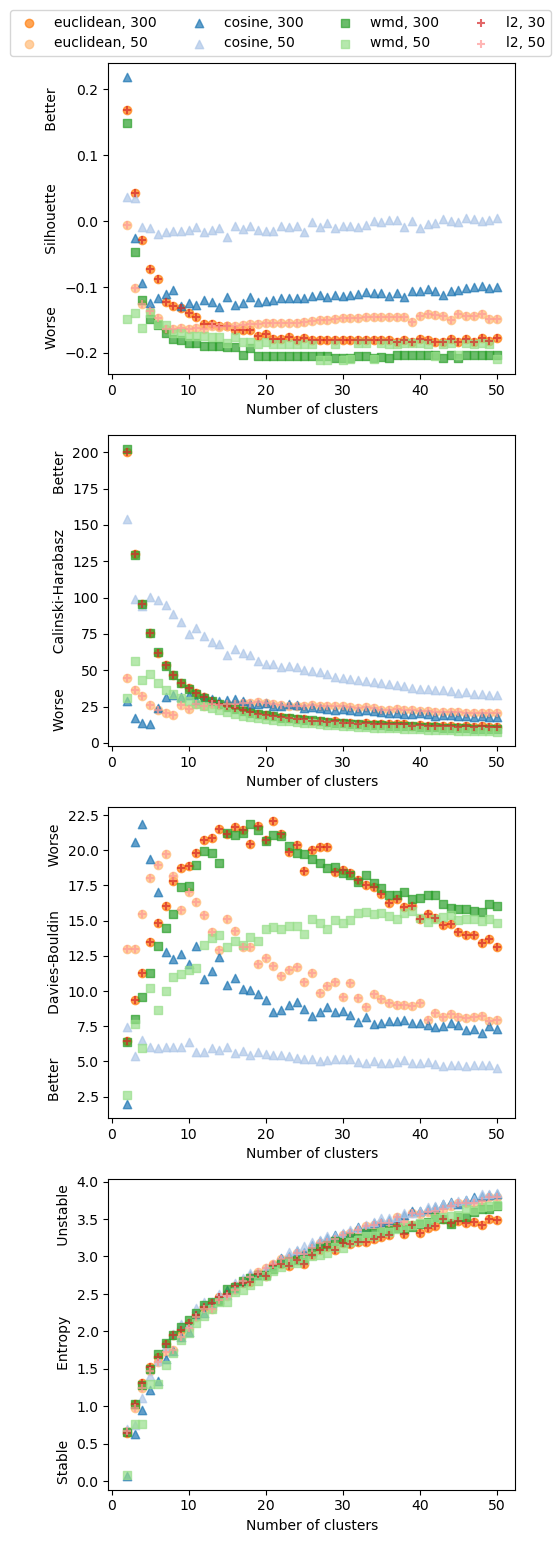

In [7]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=4)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_4_lt_10


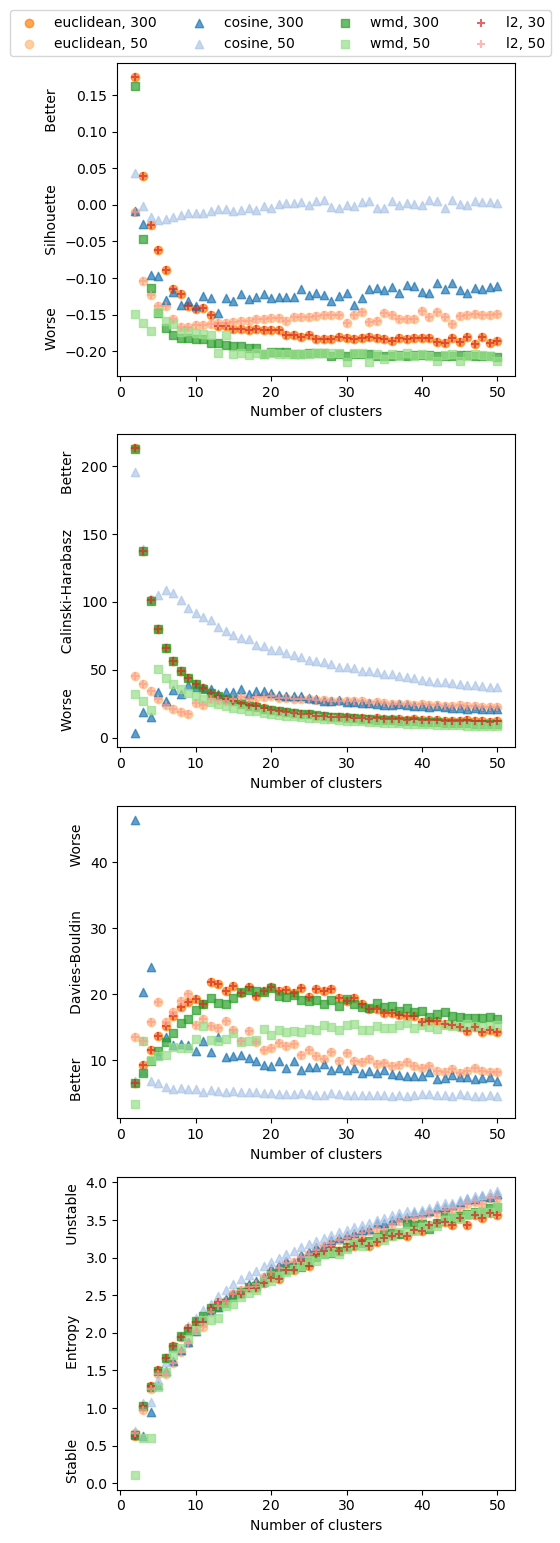

In [8]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=4)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_10


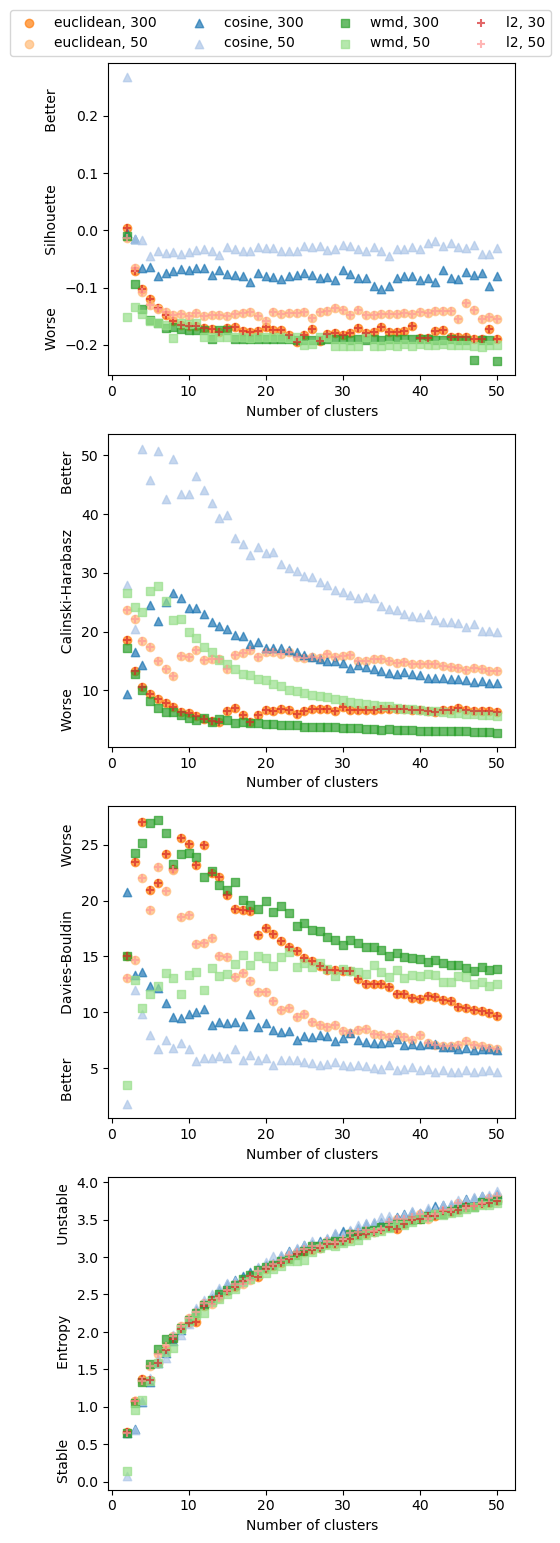

In [9]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=4)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

# DBSCAN 

In [10]:
df_dbscan

distance       dataset  epsilon  min_pts  n_clusters  sl_score  \
30797        wmd   chains_eq_2     0.48       13           1       NaN   
30957        wmd   chains_eq_2     0.60        5           1       NaN   
30958        wmd   chains_eq_2     0.60        6           1       NaN   
30959        wmd   chains_eq_2     0.60        7           1       NaN   
30960        wmd   chains_eq_2     0.60        8           1       NaN   
...          ...           ...      ...      ...         ...       ...   
21050  euclidean  chains_ge_10     0.35       10           1       NaN   
21051  euclidean  chains_ge_10     0.35       11           1       NaN   
21052  euclidean  chains_ge_10     0.35       12           1       NaN   
20982  euclidean  chains_ge_10     0.30       12           1       NaN   
36959     cosine  chains_ge_10     1.00       15           1       NaN   

       ch_score  db_score  entropy  nn  n_noise  Unnamed: 9   size  \
30797       NaN       NaN      NaN NaN     21.0         NaN  23841   
30957       NaN       NaN      NaN NaN      4.0         NaN  23841   
30958       NaN       NaN      NaN NaN      4.0         NaN  23841   
30959       NaN       NaN      NaN NaN      4.0         NaN  23841   
30960       NaN       NaN      NaN NaN      4.0         NaN  23841   
...         ...       ...      ...  ..      ...         ...    ...   
21050       NaN       NaN      NaN NaN   5231.0         NaN   5324   
21051       NaN       NaN      NaN NaN   5231.0         NaN   5324   
21052       NaN       NaN      NaN NaN   5231.0         NaN   5324   
20982       NaN       NaN      NaN NaN   5231.0         NaN   5324   
36959       NaN       NaN      NaN NaN      NaN         NaN   5324   

       prop_noise dimensions  order          name    k_noise  method  
30797    0.000881         50      0      CL $= 2$  1 (0.001)  DBSCAN  
30957    0.000168         50      0      CL $= 2$  1 (0.000)  DBSCAN  
30958    0.000168         50      0      CL $= 2$  1 (0.000)  DBSCAN  
30959    0.000168         50      0      CL $= 2$  1 (0.000)  DBSCAN  
30960    0.000168         50      0      CL $= 2$  1 (0.000)  DBSCAN  
...           ...        ...    ...           ...        ...     ...  
21050    0.982532        300      3  CL $\geq$ 10  1 (0.983)  DBSCAN  
21051    0.982532        300      3  CL $\geq$ 10  1 (0.983)  DBSCAN  
21052    0.982532        300      3  CL $\geq$ 10  1 (0.983)  DBSCAN  
20982    0.982532        300      3  CL $\geq$ 10  1 (0.983)  DBSCAN  
36959         NaN        300      3  CL $\geq$ 10    1 (nan)  DBSCAN  

[36960 rows x 19 columns]

In [11]:
iter_dataset = iter(df_dbscan.sort_values(by='order')['dataset'].unique())

chains_eq_2


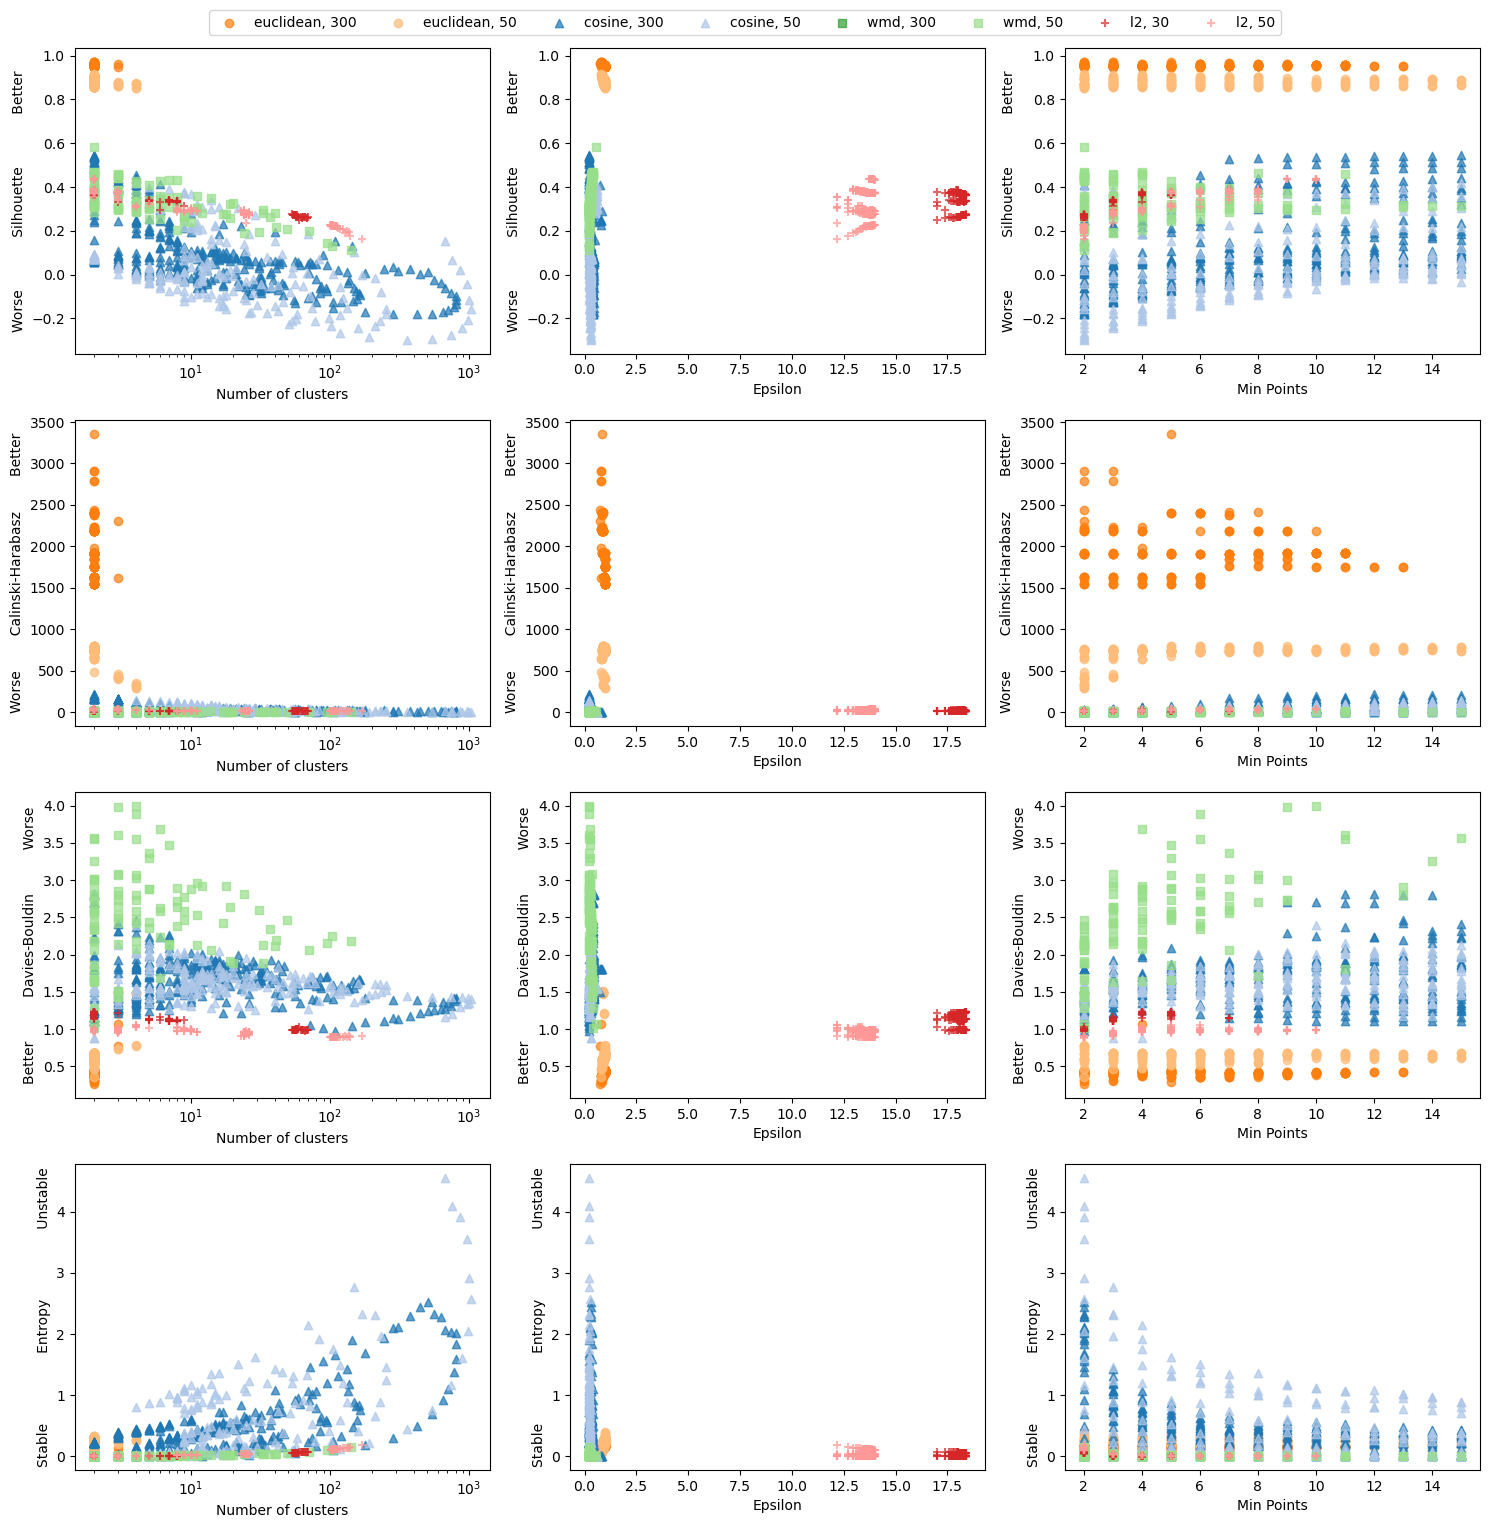

In [12]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_dbscan.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_eq_3


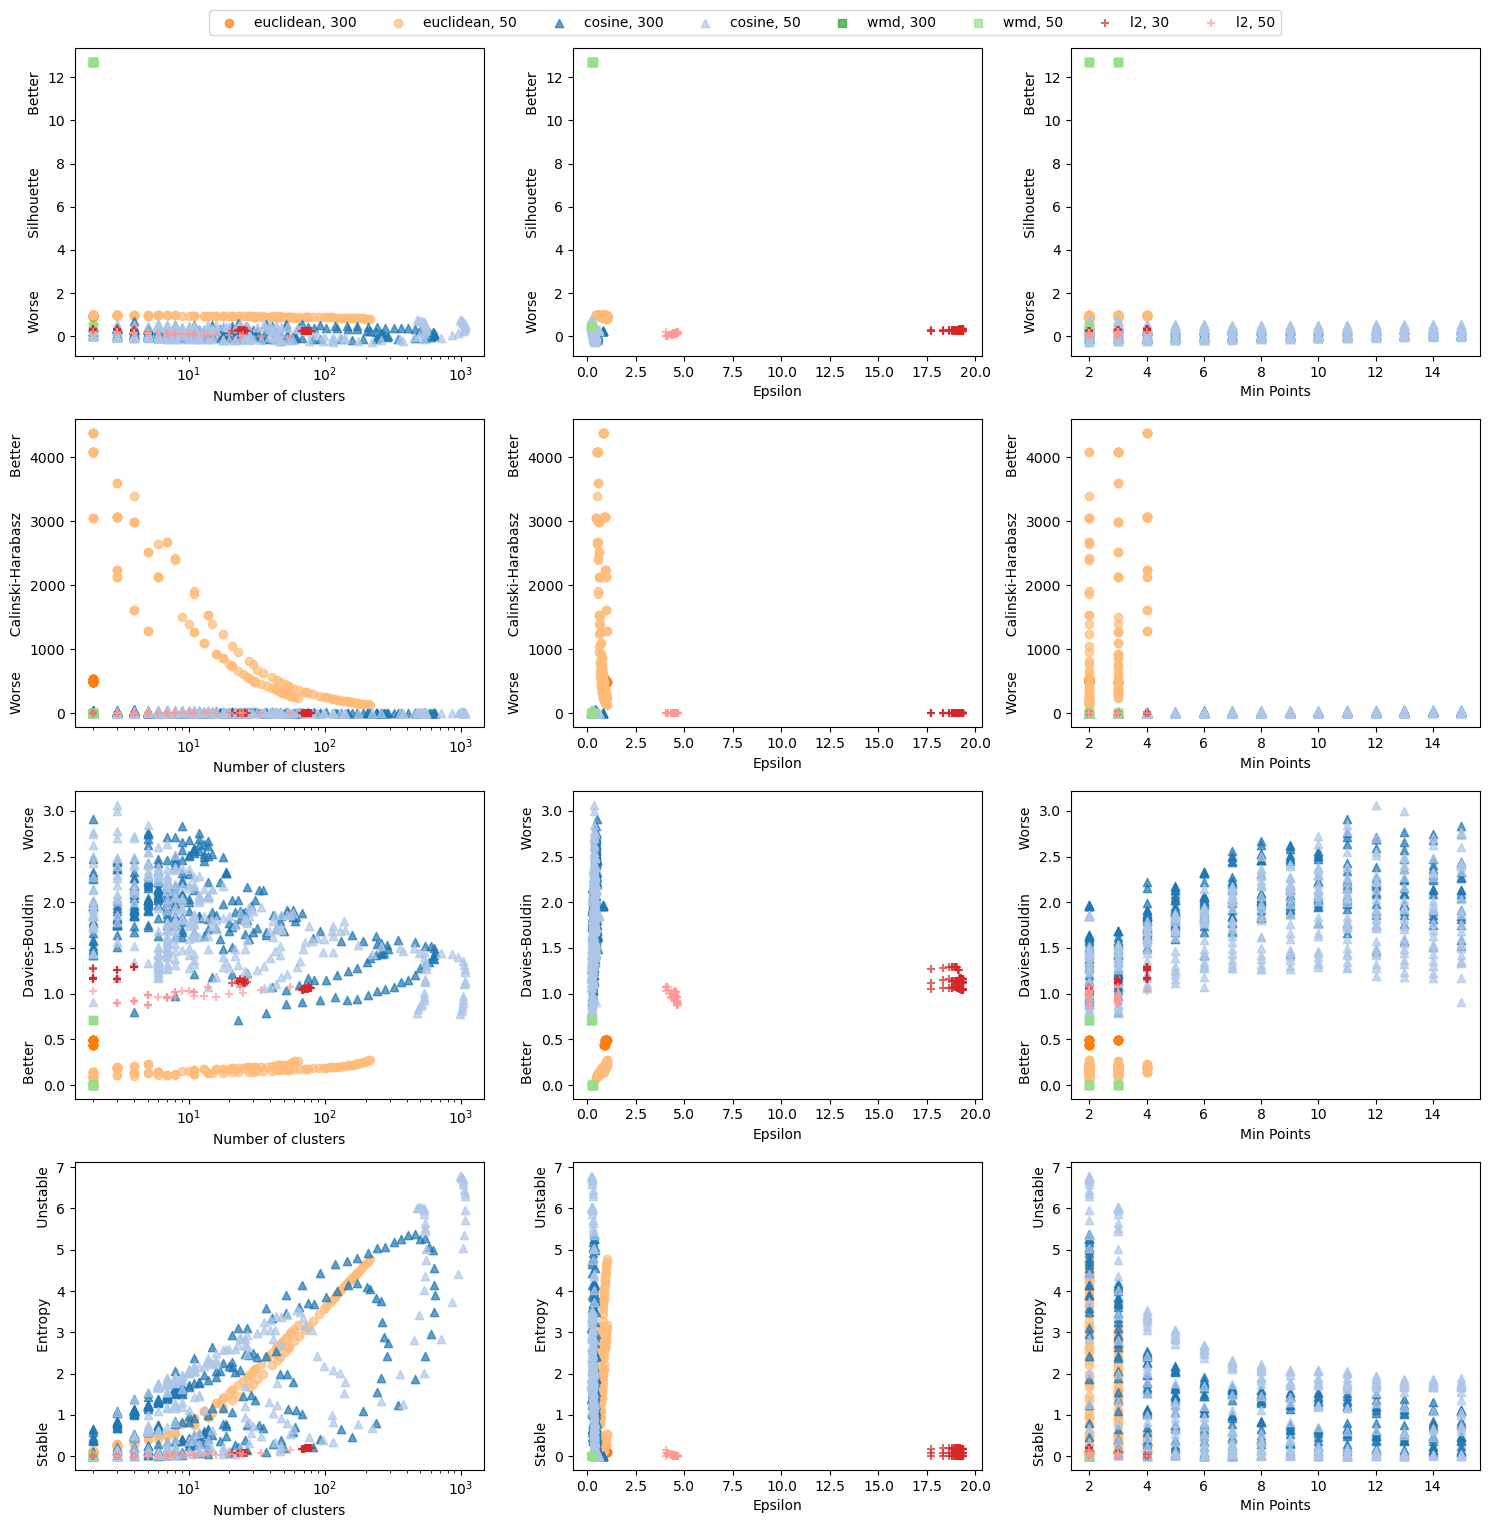

In [13]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna(how='all', subset=scores).loc[df_dbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_4_lt_10


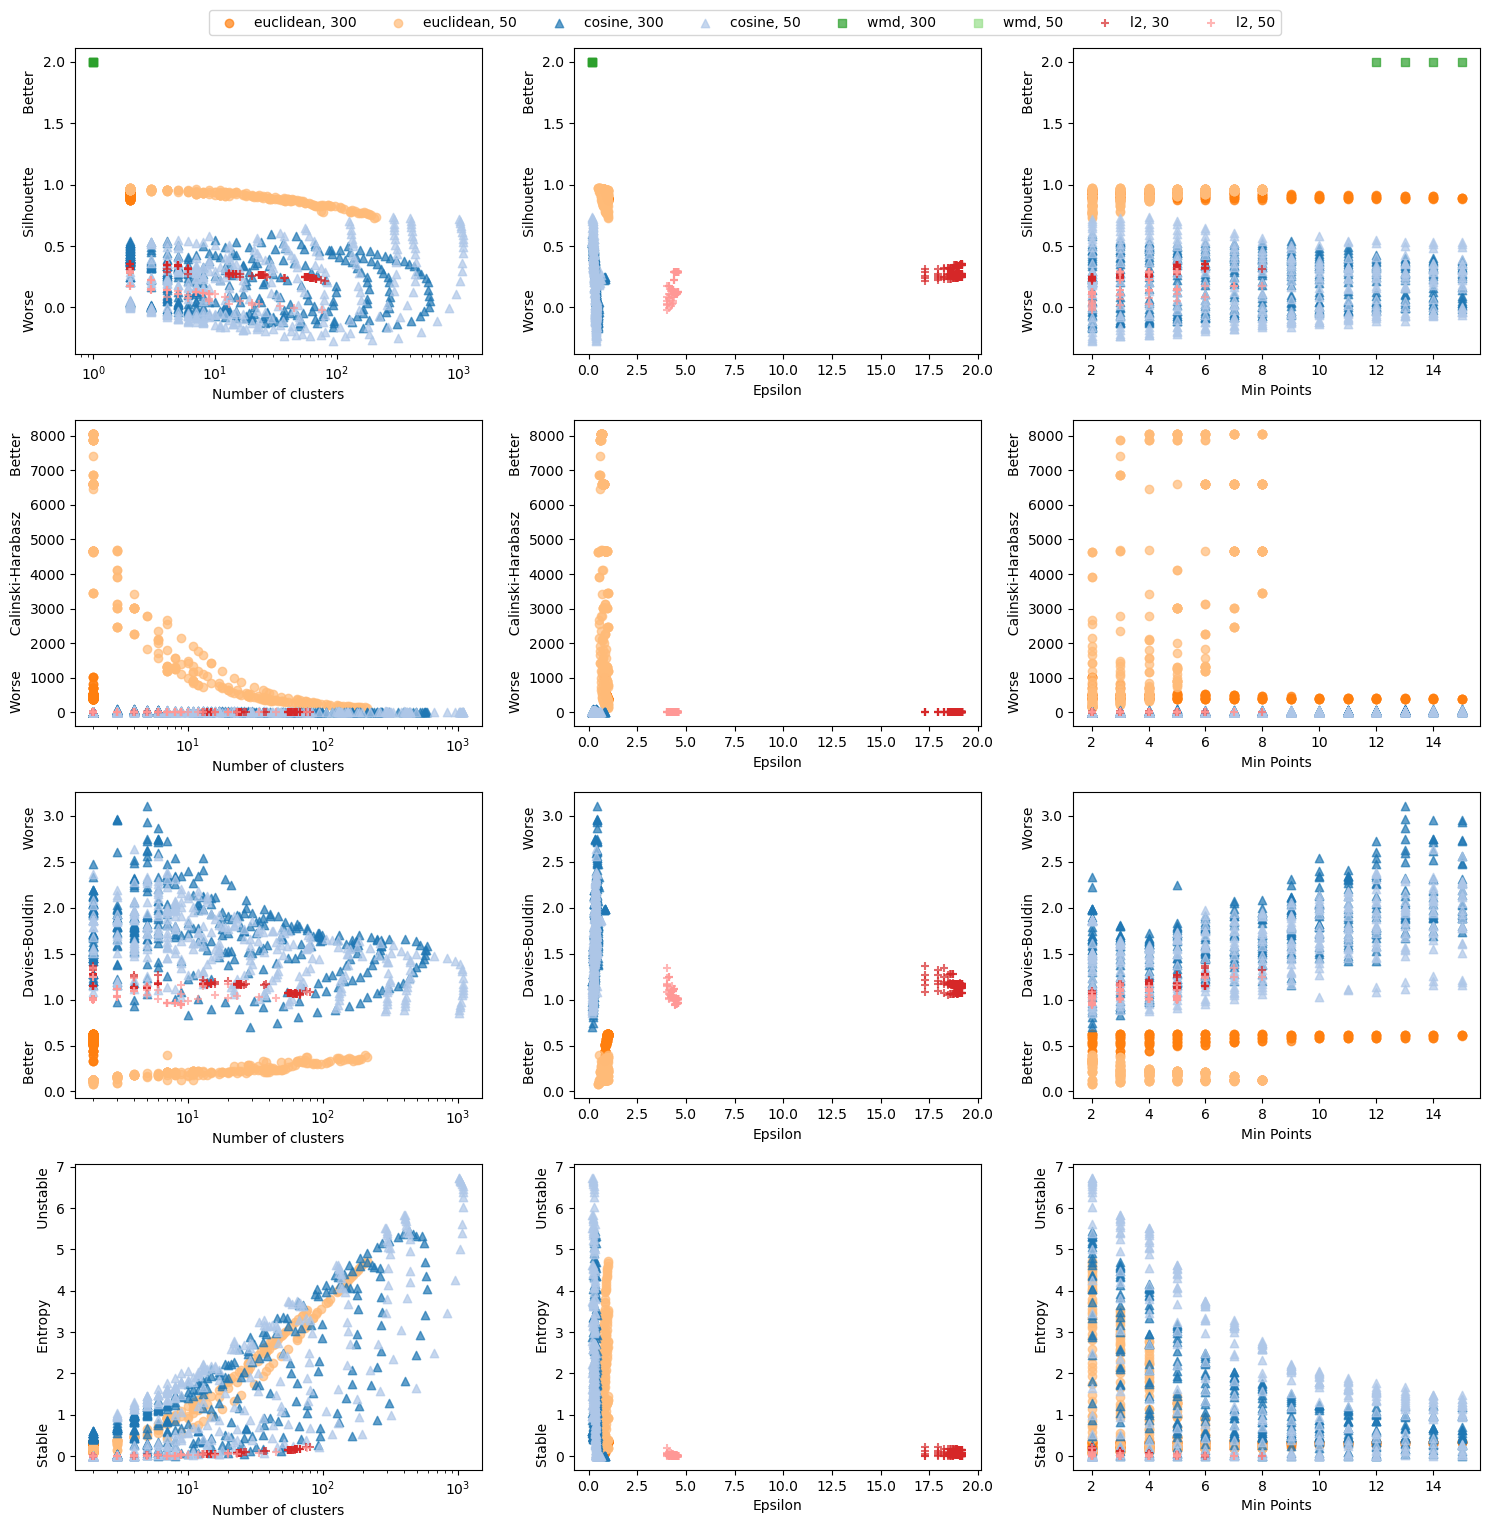

In [14]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna(how='all', subset=scores).loc[df_dbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_10


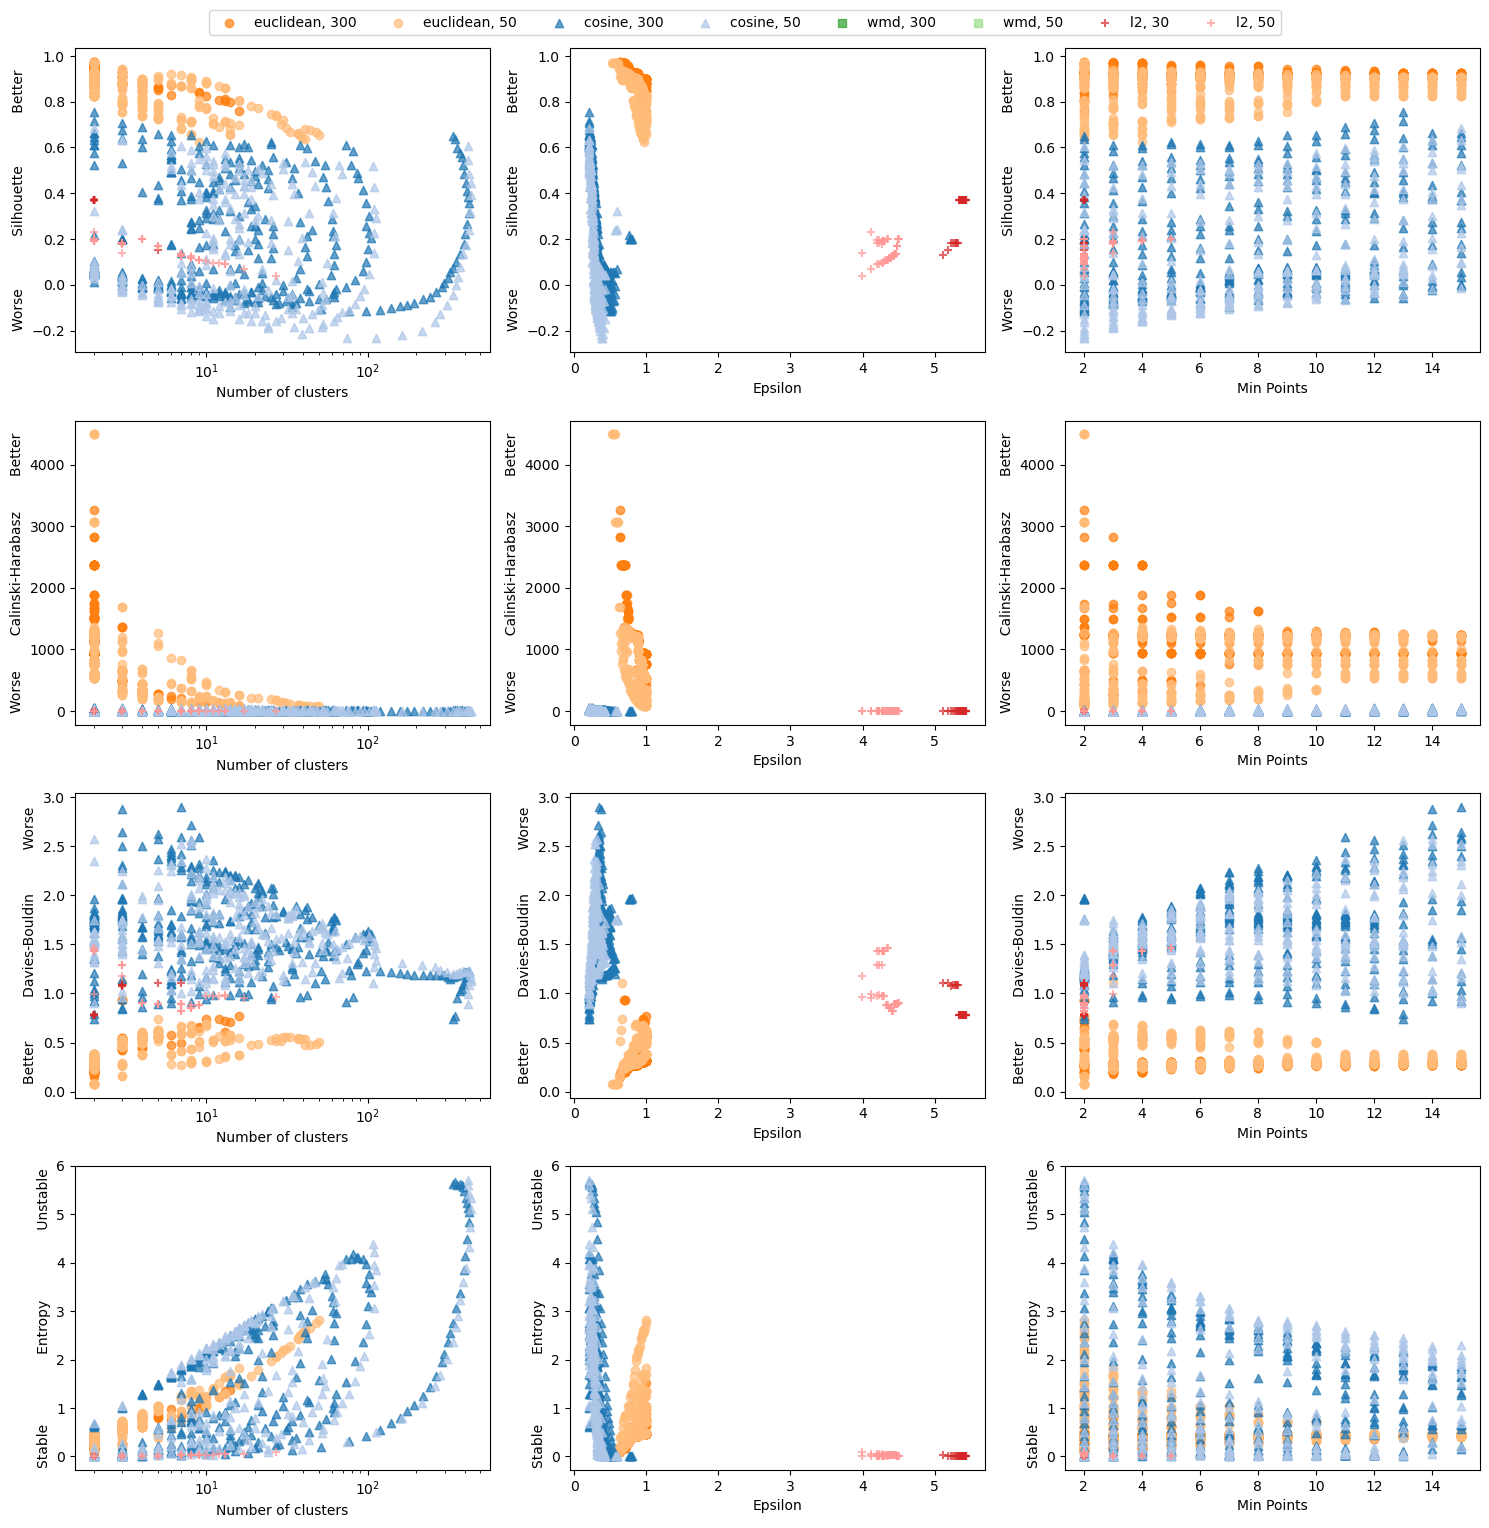

In [15]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna(how='all', subset=scores).loc[df_dbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

# HDBSCAN

In [16]:
df_hdbscan.sort_values(by='order')['dataset'].unique()

array(['chains_eq_3', 'chains_ge_4_lt_10', 'chains_ge_10'], dtype=object)

In [17]:
iter_dataset = iter(df_hdbscan.sort_values(by='order')['dataset'].unique())

chains_eq_3


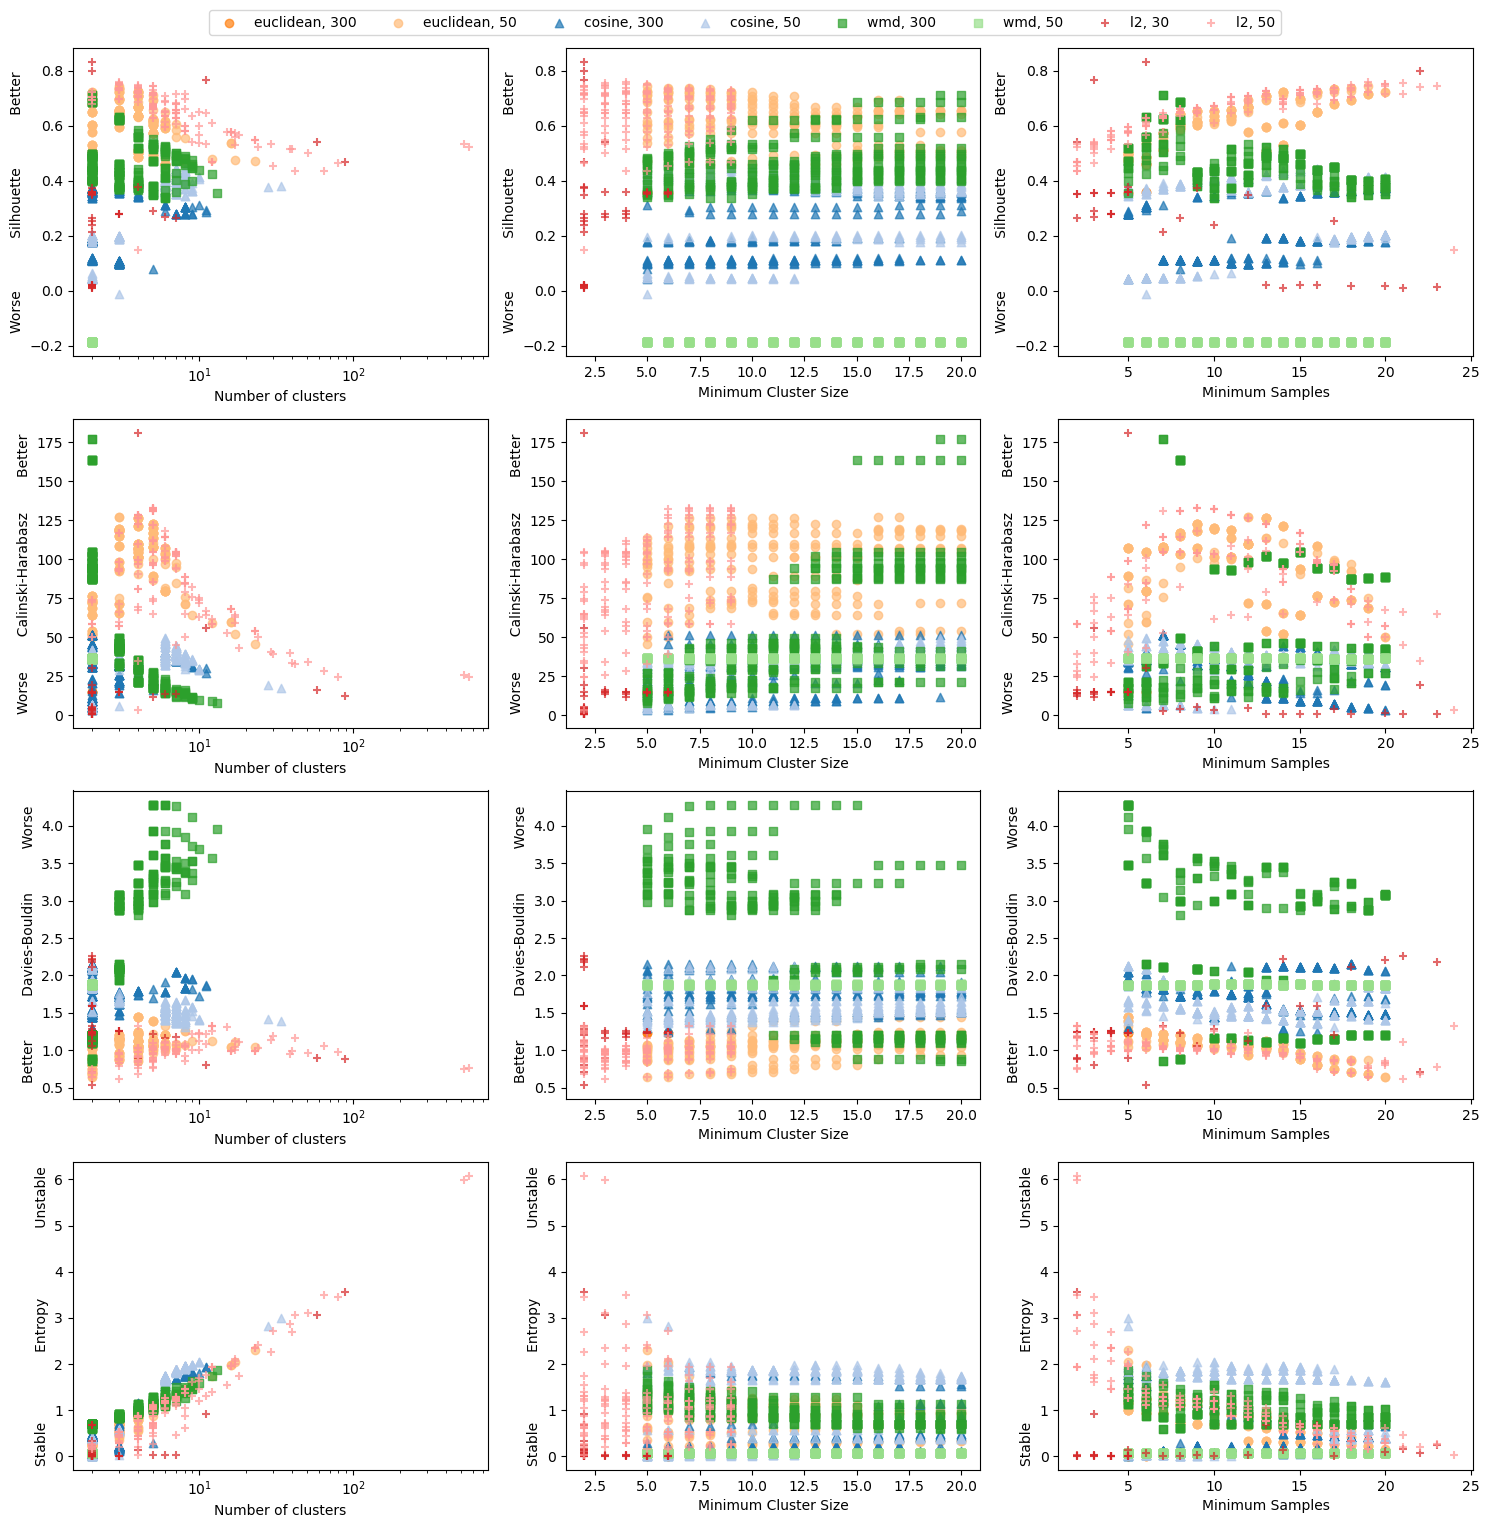

In [18]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_4_lt_10


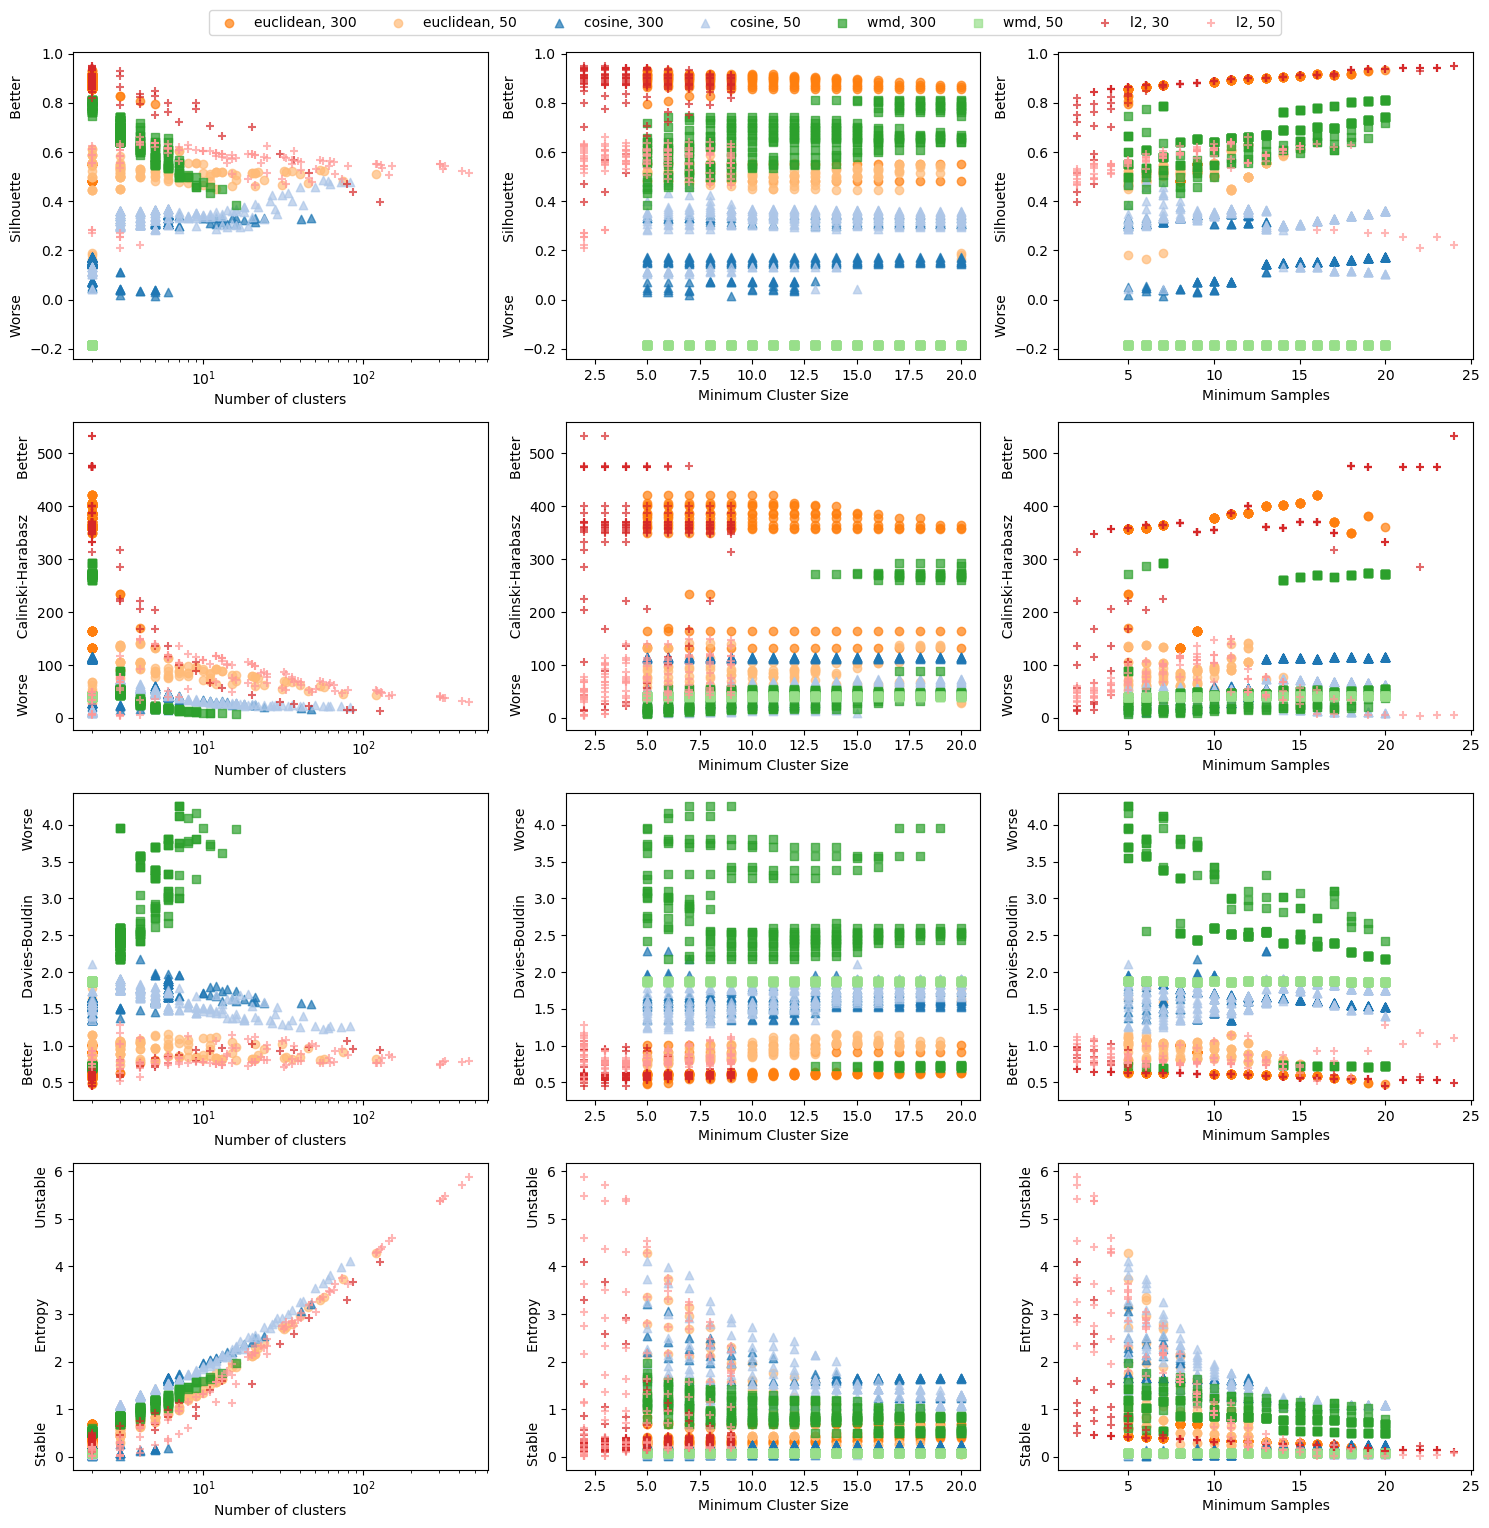

In [19]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_10


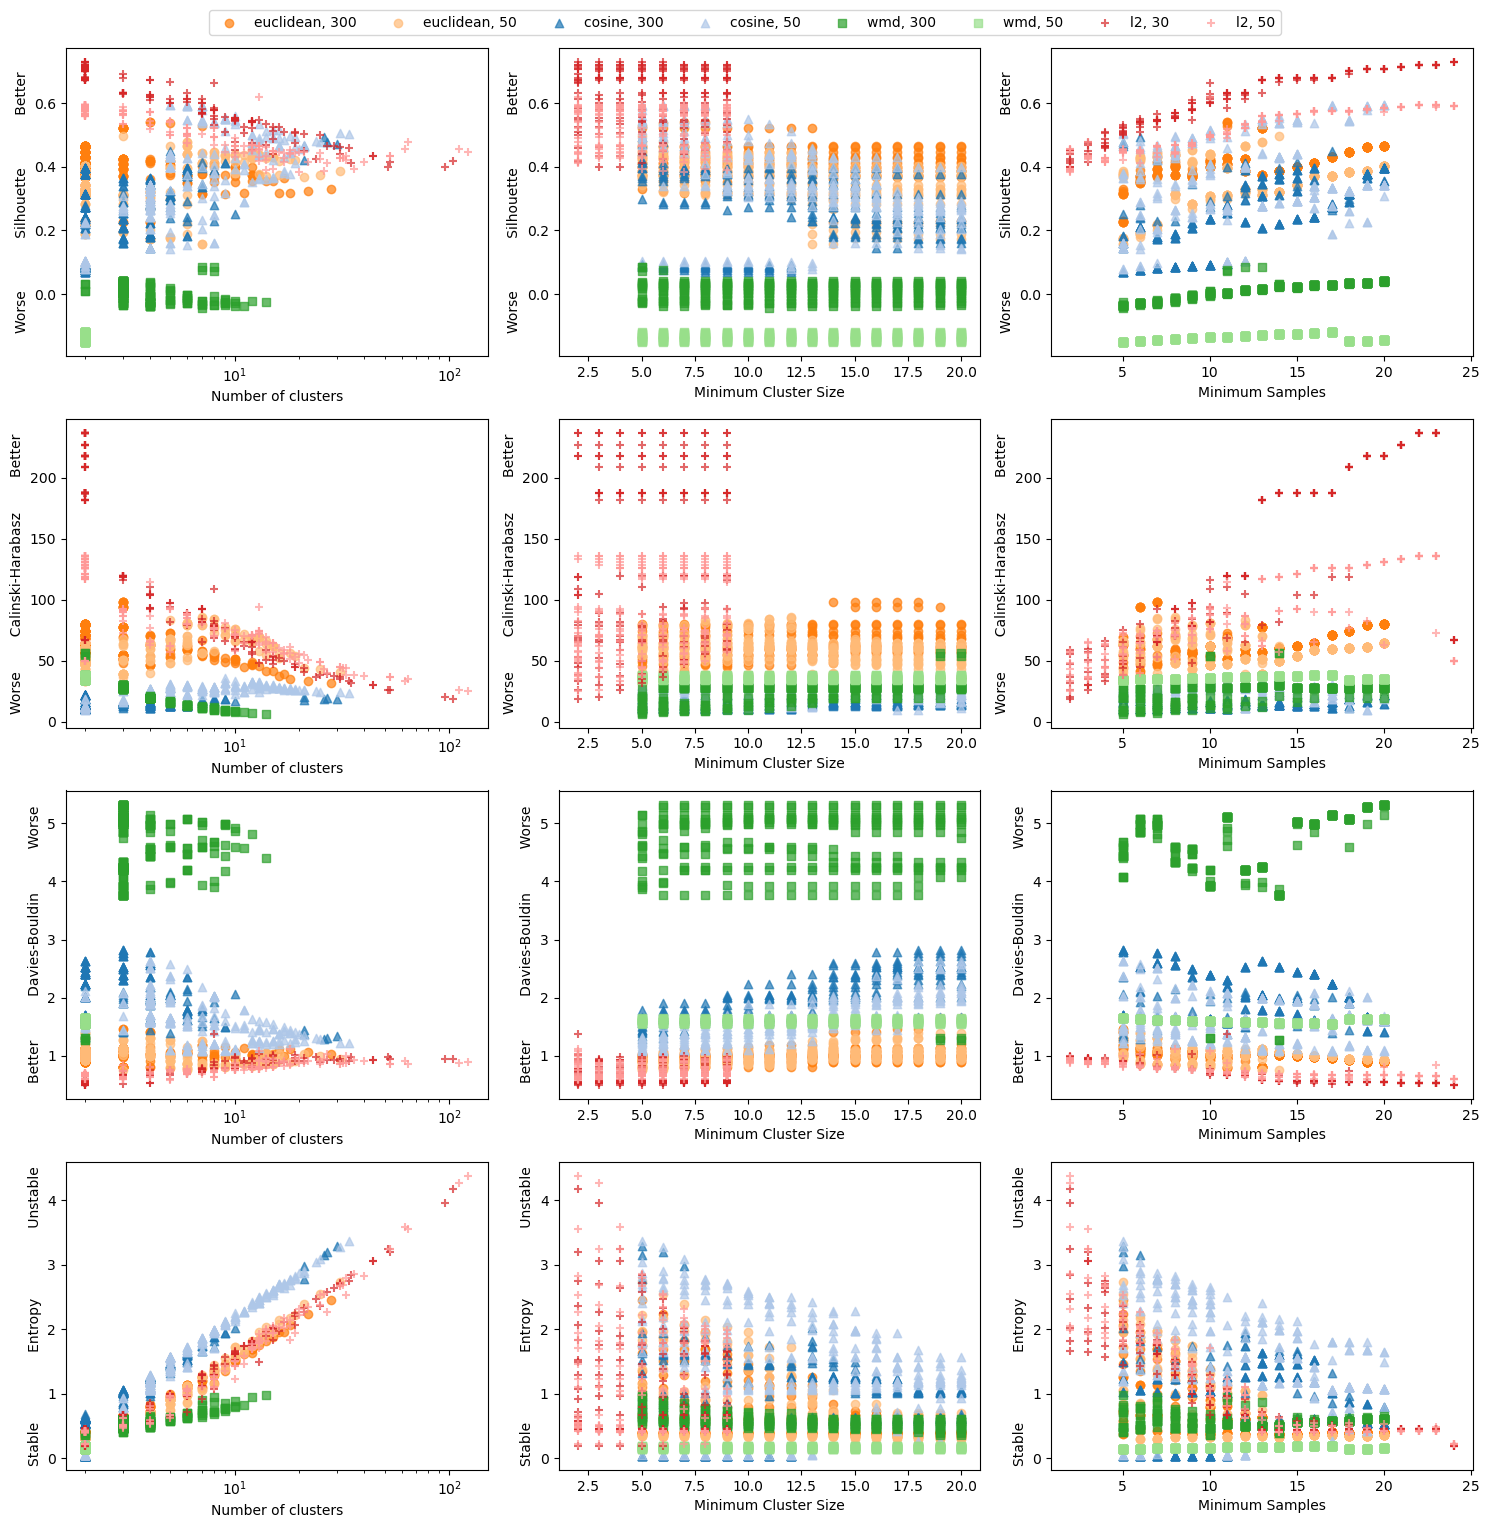

In [20]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()